In [52]:
# change pdb chain id

pdb_fpath = '/home/lwang/models/HDOCKlite-v1.1/pdb/AF_ELF5A.pdb'
chain_revise = {'A': 'E'}
new_lines = []

with open(pdb_fpath, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('ATOM'):
            chain_id = line[21]
            if chain_id in chain_revise.keys():
                line = line[:21] + chain_revise[chain_id] + line[22:]
        new_lines.append(line)

with open(pdb_fpath, 'w') as f:
    f.writelines(new_lines)

In [ ]:
# trim PDB by PLDDT score
from Bio import PDB

cutoff = 70

# Load the PDB file
pdb_file = "path/to/pdb/file.pdb"
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("structure", pdb_file)

# Iterate over the residues and remove those with average pLDDT score below the cutoff
for model in structure:
    for chain in model:
        residues_to_remove = []
        for residue in chain:
            b_factors = [atom.bfactor for atom in residue]
            average_bfactor = sum(b_factors) / len(b_factors)
            if average_bfactor < cutoff:
                residues_to_remove.append(residue.id)

        # Detach residues that have an average pLDDT < cutoff
        for residue_id in residues_to_remove:
            chain.detach_child(residue_id)

# Save the trimmed structure to a new PDB file
output_file = "path/to/output/file.pdb"
io = PDB.PDBIO()
io.set_structure(structure)
io.save(output_file)


In [ ]:
# remove alternate residues in pdb file
from Bio import PDB

def remove_alternate_residues(input_pdb, output_pdb):
    parser = PDB.PDBParser(QUIET=True)
    io = PDB.PDBIO()
    
    # Parse structure
    structure = parser.get_structure('structure', input_pdb)
    
    # Define a function to filter residues with alternate locations
    class AltLocSelect(PDB.Select):
        def accept_atom(self, atom):
            # If the atom does not have an alternate location, keep it
            if atom.altloc == ' ' or atom.altloc == 'A':
                return True
            # Keep the atom only if it's from the highest occupancy conformation
            return False
    
    # Write out the filtered structure
    io.set_structure(structure)
    io.save(output_pdb, AltLocSelect())

# Replace with your PDB file paths
input_pdb = "input.pdb"
output_pdb = "output_clean.pdb"

remove_alternate_residues(input_pdb, output_pdb)


In [ ]:
# rename pdb files
import os

folder_path = '/path/to/your/folder'
pdb_files = [f for f in os.listdir(folder_path) if f.endswith('.pdb')]

for i, pdb_file in enumerate(pdb_files, start=1):
    new_name = f'MODEL_{i}_LOCALDOCK.pdb'
    os.rename(os.path.join(folder_path, pdb_file), os.path.join(folder_path, new_name))

print(f'Renamed {len(pdb_files)} files.')

### docking post processing ###

1. run hdock and run_createpl.sh, the created docking file will be transfered to root_dir/hdock_files
2. revise the model pdb files, rename chain id, merge receptor and ligand records

### prepare model input ###
1. output chain fasta files for each protein
2. output esm2 embedding (maximum length of 1022)


In [2]:
import os
import shutil

root_dir = '/home/lwang/models/HDX_LSTM/data/hdock/'

In [ ]:
### output fasta file for esm2 ###
import os
import sys
sys.path.append('/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/BiLSTM+GAT_v2/pepGraph_generation/tool')
from predataprocess import get_pdb_seq
from Bio import PDB
import warnings
warnings.filterwarnings("ignore")

root_dir = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock'
src_dir = f'/home/lwang/models/HDOCKlite-v1.1/pdb'
fail_list = []

pdb_list = os.listdir(src_dir)
for pdb_name in pdb_list:
    pdb_fname = pdb_name.split('.')[0]
    #if pdb_fname.startswith('model'):
    #    continue
    print('start processing', f'{pdb_fname}')        
    if os.path.isfile(f'{src_dir}/{pdb_fname}.pdb'):
        #try:
        parser = PDB.PDBParser()
        filepath = f'{src_dir}/{pdb_fname}.pdb'
        structure = parser.get_structure('structure', filepath)
        chain_ids = list(structure.get_chains())
        for chain_id in chain_ids:
            chain_id = chain_id.get_id()
            if chain_id == 'Z': #skip the heteroatoms chain
                continue
            sequence, residue_indices = get_pdb_seq(structure, chain_id)
            if len(sequence) == 0:
                continue
            elif len(sequence) > 1022:
                print(f'{pdb_fname}_{chain_id} has more than 1022 residues:', len(sequence))
                
            if os.path.isdir(f'{root_dir}/fasta_files') == False:
                os.mkdir(f'{root_dir}/fasta_files')
            with open(f'{root_dir}/fasta_files/{pdb_fname.upper()}_{chain_id.upper()}.fasta', 'w') as f:
                f.write(f'>{pdb_fname}_{chain_id}\n')
                f.write(sequence)
        #except Exception as e:
        #    print(e)
        #    fail_list.append(pdb_fname+'_'+chain_id)
        #    continue
    else:
        print(f'{src_dir}/{pdb_fname}.pdb does not exist')
print(fail_list)

In [8]:
import esm
import torch

model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
]

batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"]

print(token_representations)

{}


### run each score functions to evaluate generated decoys:
1. zrank/zrank2
2. rosetta interface analyzer
3. dockq

In [19]:
# revise the Hdock model pdb file ###
protein_name = 'model'
reindex_chain = True
hdock_dir = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/hdock'

def Revise_HDOCK_models(model_name, src_path, dst_path, N_model, reindex_chain=True):
    """
    Reindex chain IDs in alphabetical order and save revised PDB files to the destination path.
    
    :param src_path: Source directory containing original PDB files
    :param dst_path: Destination directory to save revised PDB files
    :param protein_name: Name of the protein
    """
    dst_file = [f'{model_name}_{i}' for i in range(1, N_model)]

    if not os.path.exists(f'{dst_path}'):
        os.makedirs(f'{dst_path}')
    for pdb in dst_file:
        with open(f'{src_path}/{pdb}.pdb', 'r') as f, open(f'{dst_path}/{pdb.upper()}_REVISED.pdb', 'w') as out:
            chain_id = ord('A')  # ASCII value of 'A'
            prev_chain = None

            for line in f:
                if line.startswith('ATOM'):
                    if reindex_chain:
                        current_chain = line[21]
                        if prev_chain is not None and current_chain != prev_chain:
                            chain_id += 1
                        line = line[:21] + chr(chain_id) + line[22:]
                        prev_chain = current_chain

                    line = line[:-1] + ' 1.00  0.00           ' + line[13] + '\n'

                elif line.startswith('HEADER rec.pdb'):
                    line = line.replace('rec.pdb', f'{pdb}.pdb')
                elif line.startswith('HEADER lig') or line.startswith('SHEET') or line.startswith('HELIX') or line.startswith('CONECT'):
                    continue

                out.write(line)

for folder in os.listdir(hdock_dir):
    print('processing', folder)
    src_path = f'{hdock_dir}/{folder}'
    dst_path = f'{hdock_dir}/../structure/{folder}'
    N_model = len(os.listdir(src_path))
    Revise_HDOCK_models(protein_name, src_path, dst_path, N_model, reindex_chain=True)

processing Delta_fold_vh16_vl106_seed2_model_0
processing Delta_fold_vh16_vl106_seed4_model_0
processing Delta_fold_vh16_vl106_seed4_model_1
processing Delta_fold_vh16_vl106_seed4_model_2
processing Delta_fold_vh16_vl106_seed5_model_2
processing Omicron_fold_vh16_vl106_seed2_model_0
processing Omicron_fold_vh16_vl106_seed4_model_0
processing Omicron_fold_vh16_vl106_seed4_model_1
processing Omicron_fold_vh16_vl106_seed4_model_2
processing Omicron_fold_vh16_vl106_seed5_model_2
processing Wuhan_fold_vh16_vl106_seed2_model_0
processing Wuhan_fold_vh16_vl106_seed4_model_0
processing Wuhan_fold_vh16_vl106_seed4_model_1
processing Wuhan_fold_vh16_vl106_seed4_model_2
processing Wuhan_fold_vh16_vl106_seed5_model_2


In [22]:
### trim pdb files for faster feature extraction (SASA and HSE) ###
import numpy as np
from Bio.PDB import PDBParser, PDBIO, Select

def Trim_HDOCK_PDB(pdb_file, save_fpath, chain_range_dict):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)
    io = PDBIO()

    class SelectResidues(Select):
        def accept_residue(self, residue):
            chain_id = residue.get_parent().id
            if chain_id in chain_range_dict.keys():
                for start, end in chain_range_dict[chain_id]:
                    if start <= residue.id[1] <= end:
                        return True
            else:
                return True
            return False
    io.set_structure(structure)
    io.save(save_fpath, select=SelectResidues())

chain_range_dict = {
    'A': [(1,290), (320,590)],
    'B': [(1,290), (320,590)],
    'C': [(1,290), (320,590)],
}

pdb_dir = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/structure'
for folder in os.listdir(hdock_dir):
    print('processing', folder)
    src_path = f'{hdock_dir}/../structure/{folder}'
    dst_path = f'{hdock_dir}/../structure/{folder}'

    for pdb in os.listdir(src_path):
        pdb_file = f'{src_path}/{pdb}'
        save_fpath = f'{dst_path}/{pdb[:-4]}_TRIM.pdb'
        Trim_HDOCK_PDB(pdb_file, save_fpath, chain_range_dict)
    break

processing Delta_fold_vh16_vl106_seed2_model_0


In [ ]:
# add hydrogens to pdb files
import os
import shutil

def hbplus(hbplus_dir, pdb_dir, pdb_fname_list, save_dir):
    os.environ['PATH'] += os.pathsep + hbplus_dir
    os.chdir(hbplus_dir)
    count = 0
    for pdb in pdb_fname_list:
        if not pdb.endswith('.pdb'):
            continue
        filename = pdb.split('.')[0]
        src_file = os.path.join(pdb_dir, f'{filename}.pdb')
        command = f'hbplus -O {src_file}'
        os.system(command)

        src_file = os.path.join(hbplus_dir, f'{filename}.h')
        dst_file = os.path.join(save_dir, f'{filename}_Hplus.pdb')
        shutil.move(src_file, dst_file)

        src_file = os.path.join(hbplus_dir, f'{filename}.hb2')
        dst_file = os.path.join(save_dir, f'{filename}.hb2')
        shutil.move(src_file, dst_file) 
        count+=1
    print(f'pdb file dir: {pdb_dir}')
    print(f'{count} pdb files are saved in {save_dir}')

hbplus_dir = '/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/prog/hbplus'
root_dir = f'/home/lwang/models/HDX_LSTM/data/hdock/structure'
protein_name = '8A0E_ori'
pdb_dir = f'{root_dir}/{protein_name}'

save_dir = f'{pdb_dir}/hbplus'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

hbplus(hbplus_dir, pdb_dir, os.listdir(pdb_dir), save_dir)

In [78]:
# run DockQ to evaluate the quality of Hdock decoys
import os
import sys
from DockQ.DockQ import load_PDB, run_on_all_native_interfaces
import pickle
import numpy as np

def merge_chains(model, chains_to_merge):
    for chain in chains_to_merge[1:]:
        for i, res in enumerate(model[chain]):
            res.id = (chain, res.id[1], res.id[2])
            model[chains_to_merge[0]].add(res)
        model.detach_child(chain)
    model[chains_to_merge[0]].id = "".join(chains_to_merge)
    return model

root_dir = '/home/lwang/models/HDX_LSTM/data/hdock/structure/'
protein_name = '8F7A_ori'
N_decoys = 1000 #len(os.listdir(f'{root_dir}/{protein_name}'))
hdock_dir = f'{root_dir}/{protein_name}'
model_list = [f'MODEL_{i}_REVISED.pdb' for i in range(1, N_decoys+1)]
mapping = {"A": "A", "B": "B"}

dockq_results = []
native = load_PDB(f'/home/lwang/models/HDX_LSTM/data/hdock/structure/{protein_name[:4]}/{protein_name[:4]}.pdb')
#native = merge_chains(native, ["A", "B"])
for model in model_list:
    if not model.endswith('.pdb'):
        continue
    model_fpath = f'{hdock_dir}/{model}'
    model = load_PDB(model_fpath)
    #model = merge_chains(model, ["A", "B"])
    result = run_on_all_native_interfaces(model, native, chain_map=mapping)
    dockq_results.extend(list(result[0].values()))

with open(f'{hdock_dir}/eval/{protein_name}_dockq.pkl', 'wb') as f:
    pickle.dump(dockq_results, f)

In [ ]:
# run zrank to output the zrank score
import os
import shutil

def run_zrank(zrank_dir, pdb_list, protein_name, save_dir):
    os.environ['PATH'] += os.pathsep + zrank_dir
    os.chdir(zrank_dir)

    command = f'./zrank {pdb_list}'
    os.system(command)

    src_file = os.path.join(zrank_dir, f'zrank_{protein_name}.txt.zr.out')
    dst_file = os.path.join(save_dir, f'zrank_{protein_name}.txt.zr.out')
    shutil.move(src_file, dst_file)

def run_zrank2(zrank_dir, pdb_list, protein_name, save_dir):
    os.environ['PATH'] += os.pathsep + zrank_dir
    os.chdir(zrank_dir)

    command = f'./zrank -R {pdb_list}'
    os.system(command)

    src_file = os.path.join(zrank_dir, f'zrank2_{protein_name}.txt.zr.out')
    dst_file = os.path.join(save_dir, f'zrank2_{protein_name}.txt.zr.out')
    shutil.move(src_file, dst_file)

def clean_pdb(fpath, lig_chain='B'):
    with open(fpath, 'r') as f, open(fpath.replace('.pdb', '_clean.pdb'), 'w') as out:
        ligand_found = False
        for line in f:
            if line.startswith('ATOM') and line[21] == lig_chain and not ligand_found:
                out.write('TER\n')
                ligand_found = True
            out.write(line)

zrank_dir = '/home/lwang/models/zrank_linux'
zrank2_dir = '/home/lwang/models/zrank2_linux'
root_dir = f'/home/lwang/models/HDX_LSTM/data/hdock/structure'
protein_name = '1UGH_output'
lig_chain = 'I'

pdb_dir = f'{root_dir}/{protein_name}/hbplus'
save_dir = f'{root_dir}/{protein_name}/eval'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(f'{zrank_dir}/zrank_{protein_name}.txt', 'w') as f1, open(f'{zrank2_dir}/zrank2_{protein_name}.txt', 'w') as f2:
    for file in os.listdir(pdb_dir):
        if file.endswith('_Hplus.pdb'):
            clean_pdb(f'{pdb_dir}/{file}', lig_chain)
            dst_file = file.replace('.pdb', '_clean.pdb')
            f1.write(f'{pdb_dir}/{dst_file}\n')
            f2.write(f'{pdb_dir}/{dst_file}\n')

run_zrank(zrank_dir, f'{zrank_dir}/zrank_{protein_name}.txt', protein_name, save_dir)
run_zrank2(zrank2_dir, f'{zrank2_dir}/zrank2_{protein_name}.txt', protein_name, save_dir)

In [ ]:
# run rosetta interface analyzer

# /home/lwang/rosetta/tests/integration/tests/InterfaceAnalyzer/run_analysis.sh

In [60]:
# assemble decoys scores and dockq results, visualize the results
import pandas as pd
import numpy as np
import pickle
from scipy.stats import spearmanr
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

root_dir = '/home/lwang/models/HDX_LSTM/data/hdock/structure'

def parse_zrank_score(fpath, score_name = 'zrank_score'):
    df = pd.read_csv(fpath, sep='\s+', names=['Batch', score_name])
    df['Batch'] = df['Batch'].apply(lambda x: x.split('/')[-1])
    df['Batch'] = df['Batch'].apply(lambda x: "_".join(x.split('_')[:3]))
    return df

def parse_dockq_results(pkl_file):
    with open(pkl_file, 'rb') as f:
        dockq_results = pickle.load(f)
    data = []
    model_list = [f'MODEL_{i}_REVISED' for i in range(1, len(dockq_results)+1)]
    for result in dockq_results:
        entry = {
            'lrms': result.get('Lrms', np.nan),
            'irms': result.get('irms', np.nan),
            'fnat': result.get('fnat', np.nan),
            'dockq': result.get('DockQ', np.nan)
        }
        data.append(entry)
    df = pd.DataFrame(data, columns=['lrms', 'irms', 'fnat', 'dockq'])
    df['Batch'] = model_list
    return df

def parse_rosetta_score(fpath):
    df = pd.read_csv(fpath, sep='\s+', skiprows=1)
    cols = ['total_score','dG_cross', 'dG_cross/dSASAx100', 'dG_separated',
     'dG_separated/dSASAx100', 'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'delta_unsatHbonds', 'dslf_fa13' ,
        'fa_atr','fa_dun','fa_elec', 'fa_intra_rep', 'fa_intra_sol_xover4','fa_rep', 'fa_sol', 'hbond_E_fraction',
         'hbond_bb_sc', 'hbond_lr_bb',    'hbond_sc', 'hbond_sr_bb', 'hbonds_int', 'lk_ball_wtd', 'omega' , 'p_aa_pp', 'rama_prepro', 
         'yhh_planarity','Batch']
    df['Batch'] = df['description'].apply(lambda x: "_".join(x.split('_')[:3]))
    df = df[cols]
    return df

def max_min_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def dockq_criterion(row):
    dockq = row['dockq']
    labels = {'incorrect': 0, 'acceptable': 1, 'medium': 2, 'high': 3}
    if 0.00 <= dockq < 0.23:
        return labels['incorrect']
    elif 0.23 <= dockq < 0.49:
        return labels['acceptable']
    elif 0.49 <= dockq < 0.80:
        return labels['medium']
    elif dockq >= 0.80:
        return labels['high']

def classify_by_dockq(df, dockq_col='dockq'):
    df['dockq'] = df[dockq_col]
    df['classification'] = df.apply(dockq_criterion, axis=1)
    return df

def plot_score(df, ref_col = 'LRMS', score_col='HDX_score', x_label='LRMS', y_label='HDX_score', protein_name=None):
    # Calculate Spearman and Pearson correlation
    spearman_corr, _ = spearmanr(df[ref_col], df[score_col])
    
    plt.figure(figsize=(8, 6))
    plt.ylabel(y_label, fontsize=14, fontweight='bold')
    plt.xlabel(x_label, fontsize=14, fontweight='bold')
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Scatter plot with different colors for each classification
    palette = {0: '#0273b2', 1: '#019e73', 2: '#de8f06', 3: '#d55e00'}
    legend_labels = {0: 'Incorrect', 1: 'Acceptable', 2: 'Medium', 3: 'High'}
    colors = df['classification'].map(palette)

    plt.scatter(df[ref_col].to_numpy(), max_min_scale(df[score_col].to_numpy()), alpha=0.7, edgecolor='black', c=colors, s=20)
    
    plt.title(f'{protein_name}, SCC: {spearman_corr:.2f}', fontsize=20)
    plt.minorticks_on()
    plt.tick_params(axis='both', labelsize=12)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # Set legend with proper labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
                         markerfacecolor=palette[i], markersize=10, markeredgecolor='black') for i in range(4)]
    plt.legend(handles=handles, title='CAPRI Classification')
    
    plt.tight_layout()
    #plt.xlim(-5, 60)
    #plt.show()
    #plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240918_GVP/figures/{protein_name}_{score_col}_vs_LRMS_nearnative_revised.png', dpi=300)

,Batch,zrank_score,zrank2_score,lrms,irms,fnat,dockq,total_score,dG_cross,dG_cross/dSASAx100,...,hbond_lr_bb,hbond_sc,hbond_sr_bb,hbonds_int,lk_ball_wtd,omega,p_aa_pp,rama_prepro,yhh_planarity,classification
0,MODEL_1_REVISED,-105.1420,632.0620,2.720600,1.244757,0.682927,0.727399,1598.281,1861.433,75.914,...,-57.734,-20.264,-91.989,1.0,-36.865,18.636,-51.270,-17.016,0.003,2
142,MODEL_143_REVISED,-72.8815,351.1770,3.141436,1.495457,0.463415,0.614919,920.933,1184.122,67.301,...,-57.732,-19.743,-91.987,6.0,-34.438,18.619,-51.269,-17.015,0.003,2
703,MODEL_704_REVISED,-66.6929,96.2042,3.845662,2.172460,0.402439,0.518452,210.499,473.666,28.021,...,-57.735,-19.749,-91.988,2.0,-36.200,18.637,-51.286,-17.039,0.003,2
13,MODEL_14_REVISED,-94.8183,127.5040,5.322485,2.698884,0.426829,0.460390,679.870,942.971,48.875,...,-57.738,-19.940,-91.992,3.0,-36.277,18.640,-51.274,-17.021,0.003,1
367,MODEL_368_REVISED,-71.0589,268.2710,4.017970,2.383027,0.219512,0.440217,1264.668,1527.677,86.463,...,-57.731,-19.744,-91.983,0.0,-37.890,18.612,-51.277,-17.011,0.003,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831,MODEL_2832_REVISED,-45.0542,-2.1274,58.708228,19.545549,0.000000,0.008796,-116.981,146.276,14.156,...,-57.737,-19.776,-91.986,3.0,-37.632,18.643,-51.265,-16.987,0.003,0
2507,MODEL_2508_REVISED,-31.2111,179.9780,59.045817,19.922331,0.000000,0.008647,120.305,383.535,34.183,...,-59.269,-19.965,-91.982,3.0,-35.788,18.620,-51.274,-17.023,0.003,0
1868,MODEL_1869_REVISED,-67.0976,21.6984,58.531716,21.507827,0.000000,0.008498,23.875,287.017,22.863,...,-57.736,-19.744,-91.991,0.0,-38.140,18.638,-51.271,-17.002,0.003,0
2518,MODEL_2519_REVISED,-44.4130,-57.3487,59.483922,21.285899,0.000000,0.008317,-161.087,101.917,11.132,...,-57.739,-20.840,-91.988,1.0,-38.682,18.646,-51.284,-17.017,0.003,0


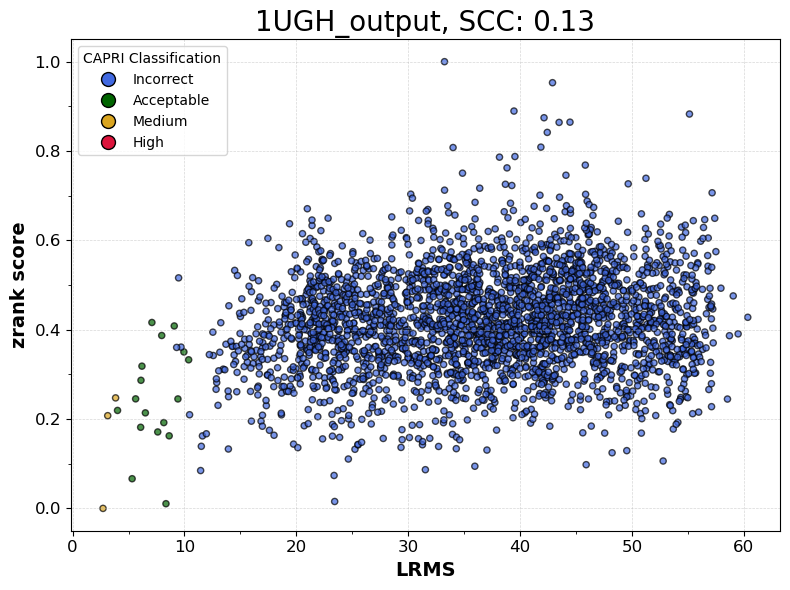

In [3]:
protein_name = '1UGH_output'

zrank_df = parse_zrank_score(f'{root_dir}/{protein_name}/eval/zrank_{protein_name}.txt.zr.out', 'zrank_score')
zrank2_df = parse_zrank_score(f'{root_dir}/{protein_name}/eval/zrank2_{protein_name}.txt.zr.out', 'zrank2_score')
dockq_df = parse_dockq_results(f'{root_dir}/{protein_name}/eval/{protein_name}_dockq.pkl')
rosetta_df = parse_rosetta_score(f'/home/lwang/rosetta/tests/integration/tests/InterfaceAnalyzer/score_{protein_name}.sc')

total_df = pd.merge(zrank_df, zrank2_df, on='Batch')
total_df = pd.merge(total_df, dockq_df, on='Batch')
total_df = pd.merge(total_df, rosetta_df, on='Batch')
total_df.sort_values(by='dockq', ascending=False, inplace=True)
total_df = classify_by_dockq(total_df, dockq_col='dockq')
display(total_df)

plot_score(total_df, ref_col ='lrms', score_col='HDX_score', y_label='zrank score', protein_name=protein_name)
#total_df.to_csv(f'/home/lwang/models/HDX_LSTM/data/hdock/prediction/1016/{protein_name}_total_scores.csv', index=False)

### Prepare sub graphs and make prediciton 
1. run /home/lwang/models/HDX_LSTM/data/Latest_test/hdock/RUN_ESM2.sh
2. edit excel records
3. run pepgraph_preprocessing.py
4. run pepGraph_prediction.py

### Re-rank decoys based on HDX score and Hdock score

In [84]:
def remove_outlier(df, column='HDX_score'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    mask = (df[column] <= upper_bound)
    return df[mask]

In [13]:
# pre-setting and load prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

protein_name = '1UGH'
cluster_id = 2
N_decoys = 1000
cluster = f'cluster{cluster_id}_8A_manual_rescale'
HDX_fpath = '/home/lwang/models/HDX_LSTM/data/hdock/HDX_files/PXD037571_revised.xlsx'

dfs = []
epochs = [60, 70, 80]
for i,epoch in enumerate(epochs):
    #fpath = f'/home/lwang/models/HDX_LSTM/data/hdock/prediction/1016/GN56_epoch{epoch}/HDX_pred_GearNet56_{protein_name}_{cluster}_v{i+1}.csv'
    fpath = f'/home/lwang/models/HDX_LSTM/data/hdock/prediction/GN56_epoch{epoch}/HDX_pred_GearNet56_{protein_name}_{cluster}_v0.csv'
    df = pd.read_csv(fpath)
    print(df.shape)
    dfs.append(df)
merged_df = pd.concat(dfs, axis=0)
average_df = merged_df.groupby(['Batch', 'Chain', 'Range', 'Y_True'])['Y_Pred'].mean().reset_index()

print(average_df.head())
print(average_df.shape)


(125622, 5)
(126000, 5)
(125622, 5)
  Batch  Chain    Range    Y_True    Y_Pred
0  1AKZ      0  101-106  0.426667  0.456021
1  1AKZ      0  102-117  0.780000  0.523743
2  1AKZ      0  102-118  0.784375  0.519446
3  1AKZ      0  102-122  0.810784  0.621667
4  1AKZ      0  104-118  0.885714  0.472255
(126126, 5)


In [29]:
# get average uptake from source HDX file
# return true_diff dictionary =  [Range]: diff
protein_name='8F7A_ori'
HDX_fpath = '/home/lwang/models/HDX_LSTM/data/hdock/HDX_files/PXD037571_revised.xlsx'
timepoints = [2,3]
cluster_id = 1

def get_true_diff(HDX_fpath, apo_states, complex_states, cluster_id):
    def get_weighted_uptake(HDX_df, protein, state, correction):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        if cluster_id == 0:
            temp_HDX_df = temp_HDX_df[temp_HDX_df['log_t']<timepoints[0]]
        elif cluster_id == 1:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']<timepoints[1]) & (temp_HDX_df['log_t']>=timepoints[0])]
        elif cluster_id == 2:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']>=timepoints[1])]
        else:
            raise ValueError('Invalid cluster_id')
        
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])

        exposures = temp_HDX_df['exposure'].unique()
        unweighted_RFU = {time:{} for time in exposures}
        for time in exposures:
            for index, row in temp_HDX_df[temp_HDX_df['exposure']==time].iterrows():
                #chain_id = int(row['Chain'])
                unweighted_RFU[time][f'{row["start"]+correction}-{row["end"]+correction}'] = row['RFU']

        grouped = temp_HDX_df.groupby(['start', 'end'])
        weighted_uptake = grouped['RFU'].mean().to_numpy()/100
        unique_pairs = grouped.groups.keys()
        x_label = [f'{start+correction}-{end+correction}' for start, end in unique_pairs]

        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo, true_complex = {}, {}
    apo_mtx, complex_mtx = {}, {}

    protein, state, correction = apo_states[0], apo_states[1], apo_states[2]
    uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_apo[l] = u
    apo_mtx.update(U_apo_mtx)

    protein, state, correction = complex_states[0], complex_states[1], complex_states[2]
    uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_complex[l] = u
    complex_mtx.update(U_complex_mtx)

    true_diff = {}
    diff_mtx = {}
    for key in true_apo.keys():
        if key in true_complex:
            true_diff[key] = true_complex[key] - true_apo[key]
            diff_mtx[key] = {t: complex_mtx[t][key] - apo_mtx[t][key] for t in apo_mtx if key in apo_mtx[t] and key in complex_mtx[t]}
    
    print('Common peptides num:', len(true_diff.keys()))
    return true_diff, diff_mtx

('RanGTP', 'Ran', 0, '8F7A_B') ('RanGTP', 'Imp9+Ran', 0, '8F7A')
Common peptides num: 89


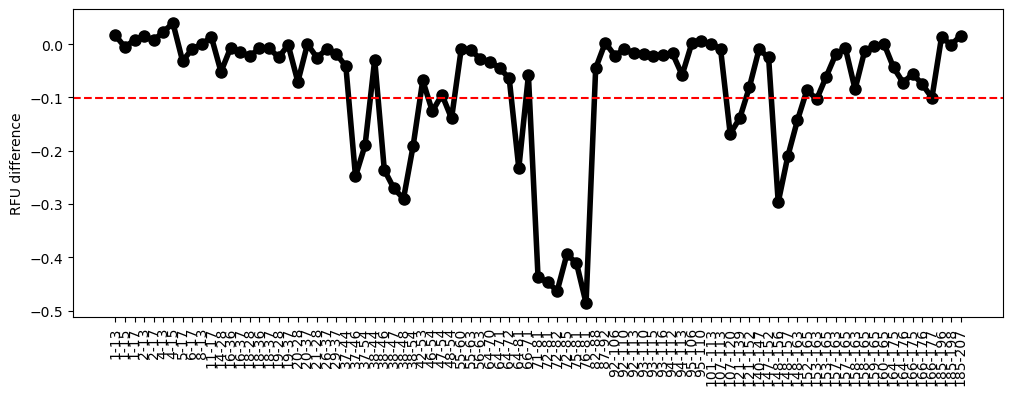

('Imp9', 'Imp9', 0, '8F7A_A') ('Imp9', 'Imp9+Ran', 0, '8F7A')
Common peptides num: 433


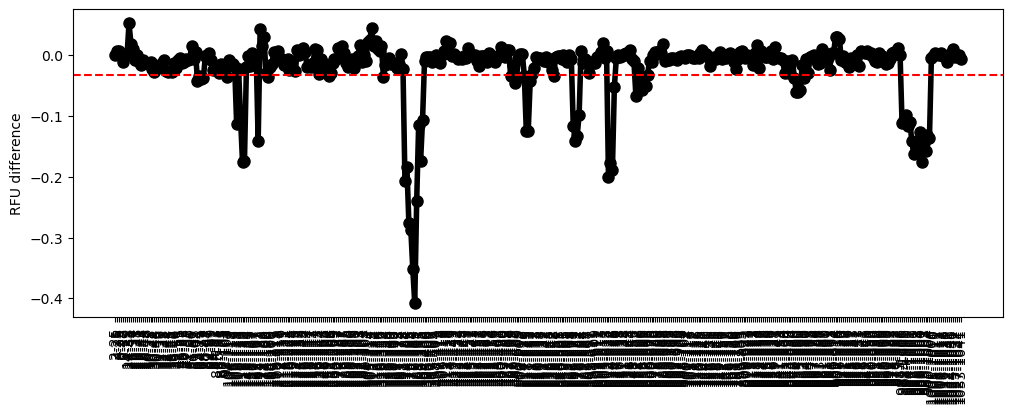

In [30]:
# plot HDX difference and find potential HDX epitopes
def plot_HDX_diff(true_diff, diff_mtx, size=(10, 6)):
    plt.figure(figsize=size)
    x_labels = list(true_diff.keys())
    x_positions = np.arange(len(x_labels))  # numerical positions for x-axis

    diff = np.array(list(true_diff.values()))
    diff_neg = diff[diff<0]
    mean_diff = np.mean(diff_neg)
    hdx_epitope_id = np.where(diff<mean_diff)[0]
    hdx_epitope_pep = [x_labels[i] for i in hdx_epitope_id]

    plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
    all_times = set()
    for diffs in diff_mtx.values():
        all_times.update(diffs.keys())
    sorted_times = sorted(all_times, key=lambda x: float(x))
    for time in sorted_times:
        time_values = [diff_mtx[label].get(time, 0) / 100 for label in x_labels]
        plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
    plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=4, markersize=8)
    plt.ylabel('RFU difference')
    plt.axhline(y=mean_diff, color='r', linestyle='--', label='Epitope cutoff')
    #plt.grid(True)
    #plt.legend()
    plt.show()

    return hdx_epitope_id, hdx_epitope_pep, sorted_times

summary_df = pd.read_excel('/home/lwang/models/HDX_LSTM/data/hdock/test_data_AF.xlsx', sheet_name='hdock')
summary_df = summary_df.dropna(subset=['match_uni'])
summary_df = summary_df[(summary_df['note']==protein_name[:4])]
grouped = summary_df.groupby(['match_uni'])

apo_states, complex_states = [], []
for name, group in grouped:
    apo_group = group[group['complex_state'] == 'single']
    complex_group = group[group['complex_state'] == 'protein complex']
    apo_states.append((apo_group['protein'].values[0], apo_group['state'].values[0], apo_group['correction_value'].values[0], apo_group['structure_file'].values[0]))
    complex_states.append((complex_group['protein'].values[0], complex_group['state'].values[0], complex_group['correction_value'].values[0], complex_group['structure_file'].values[0]))

hdx_epitope_peps = []
hdx_true_diffs = []
for apo, complex in zip(apo_states, complex_states):
    print(apo, complex)
    true_diff, diff_mtx = get_true_diff(HDX_fpath, apo, complex, cluster_id)
    epitope_id, epitope_pep, hdx_times = plot_HDX_diff(true_diff, diff_mtx, size=(12,4))
    hdx_true_diffs.append(true_diff)
    hdx_epitope_peps.append(epitope_pep)

In [31]:
# ouput the HDX epitope peptides
def to_ranges(numbers):
    if not numbers:
        return []
    
    ranges = []
    start = numbers[0]
    prev = numbers[0]

    for num in numbers[1:]:
        if num == prev + 1:
            # Continue the current range
            prev = num
        else:
            # End of the current range
            ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
            start = num
            prev = num
    
    # Add the last range
    ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
    return ranges

def to_numbers(range_list):
    all_numbers = set()
    for r in range_list:
        start, end = map(int, r.split('-'))
        all_numbers.update(range(start, end + 1))
    return sorted(all_numbers)

for i, epitopes in enumerate(hdx_epitope_peps):
    all_numbers = to_numbers(epitopes)
    ranges = to_ranges(all_numbers)
    print(f'Epitopes for {apo_states[i][3]} and {complex_states[i][3]}:', ranges)

Epitopes for 8F7A_B and 8F7A: ['37-54', '64-85', '107-139', '148-163']
Epitopes for 8F7A_A and 8F7A: ['63-72', '93-103', '106-130', '168-173', '180-186', '252-264', '325-332', '373-395', '487-496', '514-533', '538-548', '566-582', '612-625', '652-667', '843-860', '863-880', '983-1004']


In [45]:
# HDX score calculation
from tqdm import tqdm

def root_mean_square_error(y_true, y_pred, error_limit=1):
    return np.mean((((y_true - y_pred)/error_limit) ** 2))

def prepare_data(complex_batch, apo_states, complex_states, hdx_true_diffs, hdx_epitope_peps=None):
    truth = []
    pred = []
    if complex_batch not in average_df['Batch'].values:
        return None, None
    if hdx_epitope_peps is None:
        hdx_epitope_peps = [list(hdx_dict.keys()) for hdx_dict in hdx_true_diffs]
    for apo_state, complex_state, epitope_peps, hdx_dict in zip(apo_states, complex_states, hdx_epitope_peps, hdx_true_diffs):
        apo_batch = apo_state[-1]
        #complex_batch = complex_state[-1]
        apo_df = average_df[average_df['Batch']==apo_batch]
        complex_df = average_df[average_df['Batch']==complex_batch]

        for pep in epitope_peps:
            if pep in apo_df['Range'].values and pep in complex_df['Range'].values:
                pred_diff = complex_df.loc[complex_df['Range']==pep, 'Y_Pred'].values[0] - apo_df.loc[apo_df['Range']==pep, 'Y_Pred'].values[0]
                true_diff = hdx_dict[pep]
                truth.append(true_diff)
                pred.append(pred_diff)
    return np.array(truth), np.array(pred)

HDX_scores = []
complex_batch_list = [f'MODEL_{i}_REVISED' for i in range(1, N_decoys+1)]

for complex_batch in tqdm(complex_batch_list):
    y_true, y_pred = prepare_data(complex_batch, apo_states, complex_states, hdx_true_diffs, hdx_epitope_peps=hdx_epitope_peps)
    if y_true is None:
        continue
    hdx_score = root_mean_square_error(y_true, y_pred)
    HDX_scores.append(hdx_score)

100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]


In [6]:
'''hdx_times = [str(t) for t in hdx_times]
HDX_score_df = pd.DataFrame({'Batch': complex_batch_list, 'HDX_score': HDX_scores, 'HDX_time': ','.join(hdx_times)})
dockq_df = parse_dockq_results(f'{root_dir}/{protein_name}/eval/{protein_name}_dockq.pkl')
total_df = pd.merge(HDX_score_df, dockq_df, on='Batch')
total_df = classify_by_dockq(total_df, dockq_col='dockq')
plot_score(total_df, ref_col ='lrms', score_col='HDX_score', y_label='LRMS', protein_name=protein_name)

rank = total_df.sort_values(by='HDX_score', ascending=True)
display(rank)'''
import pandas as pd
import numpy as np
import os
import shutil

protein_name = '6DJL'
scores =['zrank_score']
for score in scores:
    total_df = pd.read_csv(f'/home/lwang/models/HDX_LSTM/data/hdock/prediction/{protein_name}_cluster1_8A_manual_rescale_HDX_scores.csv')
    total_df = total_df[total_df['Batch'].str.contains('REVISED')]
    total_df = total_df.drop_duplicates(subset=['Batch'])
    #display(total_df.sort_values(by=score, ascending=True))
    rank_df = total_df.sort_values(by=score, ascending=True)

    top_20 = total_df.nsmallest(20, score)
    for pdb in top_20['Batch'].values:
        src_fpath = f'/home/lwang/models/HDX_LSTM/data/hdock/structure/{protein_name}/{pdb}.pdb'
        dst_fpath = f'/home/lwang/models/HDX_LSTM/data/hdock/Top_N_hdx/{score}/{protein_name}/{pdb}.pdb'
        shutil.copy(src_fpath, dst_fpath)

In [ ]:
# add HDX scores to the total_df
zrank_df = parse_zrank_score(f'{root_dir}/{protein_name}/eval/zrank_{protein_name}.txt.zr.out', 'zrank_score')
#zrank2_df = parse_zrank_score(f'{root_dir}/{protein_name}/eval/zrank2_{protein_name}.txt.zr.out', 'zrank2_score')
dockq_df = parse_dockq_results(f'{root_dir}/{protein_name}/eval/{protein_name}_dockq.pkl')
#rosetta_df = parse_rosetta_score(f'/home/lwang/rosetta/tests/integration/tests/InterfaceAnalyzer/score_{protein_name}.sc')

#total_df = pd.merge(zrank_df, zrank2_df, on='Batch')
total_df = pd.merge(total_df, dockq_df, on='Batch')
#total_df = pd.merge(total_df, rosetta_df, on='Batch')
total_df.sort_values(by='dockq', ascending=False, inplace=True)
total_df = classify_by_dockq(total_df, dockq_col='dockq')

hdx_times = [str(t) for t in hdx_times]
HDX_score_df = pd.DataFrame({'Batch': complex_batch_list, 'HDX_score': HDX_scores, 'HDX_time': ','.join(hdx_times)})
merge_df = pd.merge(total_df, HDX_score_df, on='Batch')

merge_df['index']=merge_df['Batch'].apply(lambda x: int(x.split('_')[1]))
merge_df = merge_df.sort_values(by='index')
#merge_df['combine_score'] = max_min_scale(merge_df['HDX_score']) + max_min_scale(merge_df['zrank_score']) #+ max_min_scale(merge_df['total_score'])
#merge_df.to_csv(f'/home/lwang/models/HDX_LSTM/data/hdock/prediction/1016/{protein_name}_merge.csv', index=False)
#plot_df = remove_outlier(merge_df, column='lrms')

plot_score(merge_df, ref_col ='lrms', score_col='HDX_score', y_label='HDX score', protein_name=protein_name)
plot_score(merge_df, ref_col ='lrms', score_col='combine_score', y_label='combine score', protein_name=protein_name)

,Batch,Chain,Range,Y_True,Y_Pred,HDX_score_time,HDX_score,LRMS,iRMS,fnat,classification,zrank2_score,zrank_score,rosetta_score
1820,MODEL_91_NATIVE,0,104-117,0.074334,0.222606,100.02,0.120511,2.155687,1.142137,0.670588,2,-581.645,-198.587,1871.192
338,MODEL_252_NATIVE,0,104-117,0.074334,0.219022,100.02,0.125524,4.672724,2.525117,0.411765,2,-569.394,-196.117,2424.341
1524,MODEL_787_NATIVE,0,104-117,0.074334,0.221542,100.02,0.115588,2.015937,1.108444,0.647059,2,-563.066,-186.067,1944.304
1438,MODEL_748_NATIVE,0,104-117,0.074334,0.219016,100.02,0.117480,2.140345,1.108152,0.658824,2,-545.726,-183.473,1943.306
204,MODEL_192_NATIVE,0,104-117,0.074334,0.214502,100.02,0.120844,2.170780,1.148433,0.658824,2,-494.885,-182.618,2387.156


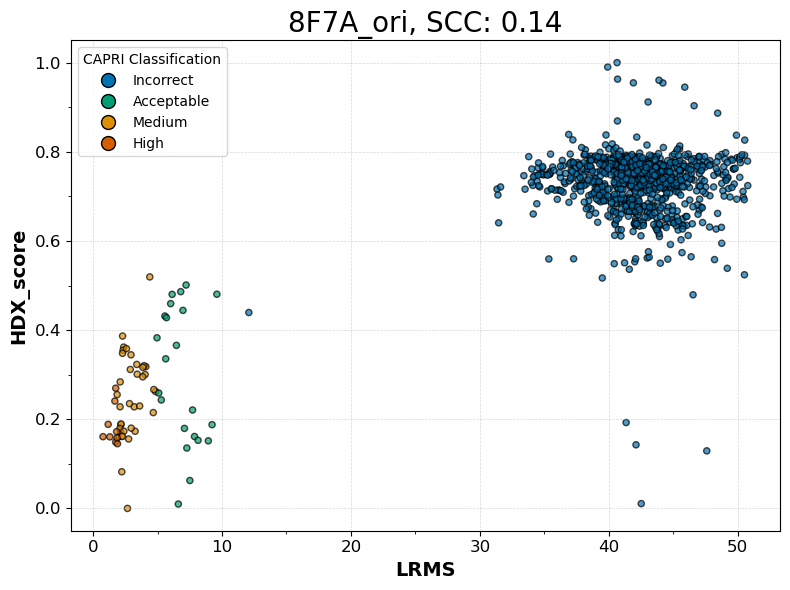

In [88]:
protein_name = '1UGH'
data_fpath = f'/home/lwang/models/HDX_LSTM/data/hdock/prediction/{protein_name}_cluster2_8A_manual_rescale_HDX_scores.csv'

df = pd.read_csv(data_fpath)
#df = df[df['Batch'].str.contains('REVISED')]
df = df[df['Batch'].str.contains('NATIVE')]
df = remove_outlier(df, column='LRMS')
df = df.drop_duplicates(subset=['Batch'])
df = df.sort_values(by='zrank_score', ascending=True)
display(df[:5])
plot_score(df, ref_col ='LRMS', score_col='HDX_score', y_label='HDX_score', protein_name=protein_name)

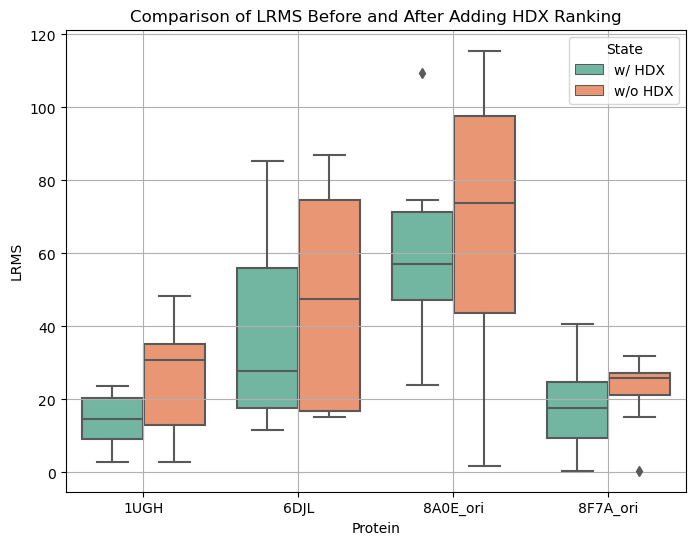

In [118]:
# load csv and check top predictions
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import spearmanr
from matplotlib.ticker import AutoMinorLocator

def apply_sigmoid_to_hdx_score(df):
    df['HDX_score'] = 1 / (1 + np.exp(-df['HDX_score']))
    return df

def remove_outlier(df, column='HDX_score'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return filtered_df

def plot_score_vs_ligand_rmsd(df, score_column='HDX_score', protein_name=None):
    # Calculate Spearman and Pearson correlation
    spearman_corr, _ = spearmanr(df['LRMS'], df[score_column])
    
    plt.figure(figsize=(8, 6))
    plt.ylabel('ITScorePP & HDX score', fontsize=14, fontweight='bold')
    plt.xlabel('Interface RMSD', fontsize=14, fontweight='bold')
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Scatter plot with different colors for each classification
    palette = {0: '#4169E1', 1: '#006400', 2: '#DAA520', 3: '#DC143C'}
    legend_labels = {0: 'Incorrect', 1: 'Acceptable', 2: 'Medium', 3: 'High'}
    colors = df['classification'].map(palette)

    plt.scatter(df['LRMS'].to_numpy(), df[score_column].to_numpy(), alpha=0.7, edgecolor='black', c=colors, s=20)
    
    plt.title(f'{protein_name}, SCC: {spearman_corr:.2f}', fontsize=20)
    plt.minorticks_on()
    plt.tick_params(axis='both', labelsize=12)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # Set legend with proper labels
    #handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
    #                      markerfacecolor=palette[i], markersize=10, markeredgecolor='black') for i in range(4)]
    #plt.legend(handles=handles, title='CAPRI Classification')
    
    plt.tight_layout()
    plt.show()

def max_min_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

protein_list = ['1UGH', '6DJL', '8A0E_ori', '8F7A_ori']
cluster_list = [2,1,1,1]
top_n = 10

dfs=[]
keep_cols = ['Batch', 'HDX_score', 'zrank_score', 'LRMS', 'iRMS', 'fnat', 'state']
for protein, cluster_id in zip(protein_list, cluster_list):
    score_df = pd.read_csv(f'/home/lwang/models/HDX_LSTM/data/hdock/prediction/{protein}_cluster{cluster_id}_8A_manual_rescale_HDX_scores.csv')

    rank_df = score_df[score_df['Batch'].str.contains('REVISED')].copy()
    rank_df = rank_df.drop_duplicates(subset=['Batch'])

    top_50 = rank_df.nsmallest(50, 'HDX_score')
    top_5 = top_50.sort_values(by='zrank_score', ascending=True)[:top_n]
    top_5['state'] = 'w/ HDX'

    zrank_top5 = rank_df.sort_values(by='zrank_score', ascending=True)[:top_n]
    zrank_top5['state'] = 'w/o HDX'

    combined_df = pd.concat([top_5[keep_cols], zrank_top5[keep_cols]]).drop_duplicates().reset_index(drop=True)
    combined_df['protein']=protein
    dfs.append(combined_df)

combined_df = pd.concat(dfs, axis=0).reset_index(drop=True)
metric = 'LRMS'

plt.figure(figsize=(8, 6))
sns.boxplot(x='protein', y=metric, hue='state', data=combined_df, palette='Set2')

plt.title(f'Comparison of {metric} Before and After Adding HDX Ranking')
plt.xlabel('Protein')
plt.ylabel(metric)
plt.legend(title='State', loc='upper right')
plt.grid(True)
plt.show()



In [181]:
def parse_PDB(PDB_path, protein_chains=['A'], atom_type_list=['N','CA','C', 'O'], size_limit=None):
    """Parse a PDB file and return the residue information.

    Args:
        key (str): Identifier for the PDB data.
        PDB_path (str): Path to the PDB file.
        protein_chain (list): List of chains to be considered.

    Returns:
        list: A list of residue information.
    """
    if not os.path.isfile(PDB_path):
        print(f"Error: File not found. {PDB_path}")
        return None
    
    chain_data = {chain: {'nodes': [], 'backbone_coord': np.zeros((4, 3), dtype=np.float32), 'last_res': 0, 'last_res_info': None} for chain in protein_chains}
    with open(PDB_path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                n_res = int(line[22:26].strip())
                res_type = line[17:20].strip()
                atom_type = line[12:16].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                chain_id = line[21].strip()
                
                if chain_id not in protein_chains:
                    #print(f"Skipping chain {chain_id}")
                    continue 
                
                chain_info = chain_data[chain_id]
                
                if n_res != chain_info['last_res']:
                    if chain_info['last_res'] != 0:  # Not the first residue
                        if size_limit is not None and len(chain_info['nodes']) >= size_limit[chain_id]:
                            continue
                        chain_info['nodes'].append(
                            {
                                'res_name': chain_info['last_res_info'][0], 
                                'residue_coord': chain_info['backbone_coord'].copy(),
                                'residue_id': chain_info['last_res_info'][1],
                                'chain_id': protein_chains.index(chain_info['last_res_info'][2])
                            }
                        )
                        chain_info['backbone_coord'] = np.zeros((4, 3), dtype=np.float32)
                    
                    chain_info['last_res'] = n_res
                    chain_info['last_res_info'] = [res_type, n_res, chain_id]

                if atom_type.strip() in atom_type_list:
                    idx = atom_type_list.index(atom_type.strip())
                    chain_info['backbone_coord'][idx] = np.array([x, y, z])
    
    # Ensure that the last residue of each chain is added
    for chain_id, chain_info in chain_data.items():
        if chain_info['last_res_info'] is not None:
            if size_limit is not None and len(chain_info['nodes']) >= size_limit[chain_id]:
                continue
            chain_info['nodes'].append(
                {
                    'res_name': chain_info['last_res_info'][0], 
                    'residue_coord': chain_info['backbone_coord'].copy(),
                    'residue_id': chain_info['last_res_info'][1],
                    'chain_id': protein_chains.index(chain_info['last_res_info'][2])
                }
            )
        else:
            raise ValueError(f"{chain_id} is not found in the PDB file.")
    
    nodes = []
    for chain_info in chain_data.values():
        for node_info in chain_info['nodes']:
            nodes.append((len(nodes),node_info))

    return nodes

In [1]:
# identify the cluster with most decoys as HDX-identified complex cluster
# output the average structure of the cluster

from Bio.PDB import *
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.transform import Rotation as R 
import numpy as np
import os
import shutil

def extract_chain_coordinates(pdb_file, chain_id):
    """
    Extracts the coordinates of all atoms in a specified chain from a PDB file.
    
    :param pdb_file: Path to the PDB file
    :param chain_id: ID of the chain to extract
    :return: A NumPy array of shape (n_atoms, 3) containing the atomic coordinates
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)
    if isinstance(chain_id, str):
        chain_id = [chain_id]

    coordinates = []
    for id in chain_id:
        chain = structure[0][id]
        for atom in chain.get_atoms():
            coordinates.append(atom.coord)
    
    return np.array(coordinates)

def average_coordinates(pdb_files, chain_id, weights=None):
    """
    Averages the coordinates of all atoms in a specified chain across multiple PDB files.
    
    :param pdb_files: List of PDB file paths
    :param chain_id: ID of the chain to average
    :return: A NumPy array of shape (n_atoms, 3) containing the averaged atomic coordinates
    """
    coords_list = []
    
    for pdb_file in pdb_files:
        coords = extract_chain_coordinates(pdb_file, chain_id)
        coords_list.append(coords)
    
    # Stack coordinates into a single array and compute the average
    coords_stack = np.stack(coords_list, axis=0)
    coords_stack = np.mean(coords_stack, axis=1)
    average_coords = np.average(coords_stack, axis=0, weights=weights)
    
    return average_coords

def quaternion_distance(q1, q2):
    return 1 - np.abs(np.dot(q1, q2))

def generate_avg_pdb(pdb_list, lig_chain, rec_chain, save_fpath, move_factor=2.0, move_step=20):
    '''
    move_factor: the factor to increase the separation distance between ligand and receptor if clash occur
    '''
    parser = PDBParser(QUIET=True)
    rec_coord = [average_coordinates([pdb_list[0]], chain) for chain in rec_chain]
    rec_center = np.mean(rec_coord, axis=0)
    max_dist = np.max(np.linalg.norm(rec_coord-rec_center, axis=1))*1.3

    lig_center = average_coordinates(pdb_list, lig_chain, weights=None)

    moving_lig_center = average_coordinates([pdb_list[0]], lig_chain)

    sup = Superimposer()
    moving_lig_atoms = []
    moving_pdb = parser.get_structure('mov', pdb_list[0])
    for chain in lig_chain:
        moving_lig_atoms.extend(list(moving_pdb[0][chain].get_atoms()))
    centered_lig_coords = [atom.get_coord() - moving_lig_center for atom in moving_lig_atoms]

    rot_mtx = []
    for fpath in pdb_list:
        ref_lig_atoms = []
        structure = parser.get_structure('ref', fpath)
        for chain in lig_chain:
            ref_lig_atoms.extend(list(structure[0][chain].get_atoms()))
        sup.set_atoms(ref_lig_atoms, moving_lig_atoms)
        rot_mtx.append(sup.rotran[0])

    quaternions = [R.from_matrix(R_mat).as_quat() for R_mat in rot_mtx]
    q_avg = np.average(quaternions,axis=0,weights = None)
    q_avg /= np.linalg.norm(q_avg)
    R_avg = R.from_quat(q_avg).as_matrix()

    superimpose_vec=rec_center-moving_lig_center
    apart_direction = rec_center - lig_center

    apart_vec = -move_step * (apart_direction/np.linalg.norm(apart_direction))
    trans_mov = superimpose_vec + apart_vec

    moving_lig_coords = np.dot(np.array(centered_lig_coords), R_avg) + moving_lig_center + trans_mov

    # Check for clashes
    rec_atoms = []
    for chain in rec_chain:
        rec_atoms.extend(list(moving_pdb[0][chain].get_atoms()))
    while True:
        distance = np.min(np.linalg.norm(moving_lig_coords - rec_center, axis=1))
        if distance <= max_dist:
            apart_vec *= move_factor  # Increase the move factor to separate further
            trans_mov = superimpose_vec + apart_vec
            moving_lig_coords = np.dot(np.array(centered_lig_coords), R_avg) + moving_lig_center + trans_mov
        else:
            break

    with open(f'{pdb_list[0]}', 'r') as f:
        lines = f.readlines()
        with open(save_fpath, 'w') as out:
            atom_num = 0
            for line in lines:
                if line.startswith('ATOM'):
                    chain_id = line[21]
                    if chain_id in lig_chain:
                        line = line[:30] + f'{moving_lig_coords[atom_num][0]:8.3f}{moving_lig_coords[atom_num][1]:8.3f}{moving_lig_coords[atom_num][2]:8.3f}' + line[54:]
                        atom_num += 1
                out.write(line)

In [6]:
clustering_setting = {
    #'protein_name': protein_name,
    'protein_name': '1UGH',
    'N': 50,
    'min_leaf_size': 2,
    'bindingsite_cutoff': 10.0, # use a coarse cutoff that allows different orientations at a close binding site
    'pose_rmsd_cutoff': 15.0,
    'atom_type_list': ['CA'],
    'rec_chain': ['E'],
    'lig_chain': ['I'],
}
pdb_file = f"/home/lwang/PDB_modelling/localDock/true_complex/{clustering_setting['protein_name']}.pdb"
save_fpath = f"{pdb_file.split('.')[0]}_seed.pdb"
print(save_fpath)

generate_avg_pdb([pdb_file], clustering_setting['lig_chain'], clustering_setting['rec_chain'], save_fpath, move_factor=2.0, move_step=40)

{'atom_type': {'node'}, 'formal_charge': {'node'}, 'explicit_hs': {'node'}, 'chiral_tag': {'node'}, 'radical_electrons': {'node'}, 'atom_map': {'node'}, 'node_position': {'node'}, 'bond_type': {'edge'}, 'bond_stereo': {'edge'}, 'stereo_atoms': {'edge'}, 'atom_name': {'node'}, 'atom2residue': {'residue reference', 'node'}, 'is_hetero_atom': {'node'}, 'occupancy': {'node'}, 'b_factor': {'node'}, 'residue_type': {'residue'}, 'residue_feature': {'residue'}, 'residue_number': {'residue'}, 'insertion_code': {'residue'}, 'chain_id': {'residue'}, 'y': {'graph'}, 'range': {'graph'}, 'chain': {'graph'}, 'is_complex': {'graph'}}


In [196]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

# Load the dataset
data = pd.read_csv('/home/lwang/models/HDX_LSTM/data/hdock/prediction/1016/1UGH_output_merge.csv', sep=',')

# Define a new set of input features and the output column
x_cols_new = ['HDX_score', 'zrank_score', 'zrank2_score', 'total_score']
y_col = 'irms'

# Prepare the input (X) and output (y) data
X_new = data[x_cols_new]
y_new = data[y_col]

# Rescale the input features to the range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_new)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_new, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
spr = spearmanr(y_test, y_pred)

# Get the coefficients of the linear regression model
coefficients = model.coef_

# Create a DataFrame to display the features with their corresponding coefficients
coefficients_df = pd.DataFrame({
    'Feature': x_cols_new,
    'Coefficient': coefficients
})

# Display results
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Spearman Correlation:", spr.correlation)
print("\nCoefficients of the linear regression model:")
print(coefficients_df)

Mean Squared Error (MSE): 8.974756119618746
R² Score: 0.12383730958859396
Mean Absolute Error (MAE): 2.3977649307071522
Spearman Correlation: 0.33658729117056985

Coefficients of the linear regression model:
        Feature  Coefficient
0     HDX_score    10.770630
1   zrank_score     5.196027
2  zrank2_score     2.687879
3   total_score    -3.691122
